## Removal of false positives in DNA-seqFISH
Based on the information of spots detected in DNA/RNA-seqFISH using 2_DNA-seqFISH_spot_detection.ipynb and 3_RNA-seqFISH_spot_detection.ipynb, we proceed to remove false positives.

In [43]:
import os
import warnings
import numpy as np
import pandas as pd
import copy
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from jie import aligner
from jie import plot
import multiprocessing.pool as mpp
from multiprocessing.pool import ThreadPool as Pool
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from scipy.spatial import distance
from scipy.stats import rankdata

# Retrieve the path of the current directory.
current_directory = os.getcwd()
# Retrieve the path two levels up from the current directory.
dir = os.path.dirname(current_directory)

warnings.filterwarnings("ignore", message="Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.")

### HELPER FXN ###
def map_to_hyb(gene_name):
    return geneID_to_hyb[gene_name]

def map_to_chrom(gene_name):
    return geneID_to_chrom[gene_name]
    

def istarmap(self, func, iterable, chunksize=1):
    self._check_running()
    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)

mpp.Pool.istarmap = istarmap


def show_nucleus(sel_pts, background = False, title = None):
    # start plot
    fig, axs = plt.subplots(1, 2, figsize =(14, 6), sharex = True)
    colors = ['red', 'green', 'blue', 'purple']

    # grab cell metadata
    sel_repl = sel_pts[0].replicate.iloc[0]
    sel_fov = sel_pts[0].FOV.iloc[0]
    sel_id = sel_pts[0].cell.iloc[0]
    sel_cell = sel_pts[0].finalcellID.iloc[0]

    ## Background
    if background == False:
        all_cell_pts = df_seqfish[(df_seqfish['finalcellID'] == sel_cell) & 
                                  (df_seqfish['chr'] == chosen_chrom)]
    else:
        all_cell_pts = df_seqfish[(df_seqfish['finalcellID'] == sel_cell)]

    axs[0].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = .1)
    axs[1].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = 0.1)

    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    ## Foreground
    # scatter plot all aligned points
    for i, elem in enumerate(sel_pts):

        for row_idx in range(elem.shape[0]):

            # skip if centromere or telomere
            if row_idx == 0:
                pass
            # otherwise plot
            else:
                # draw vectors guiding "tracing"
                x_curr, y_curr, z_curr = elem.x_hat.iloc[row_idx], elem.y_hat.iloc[row_idx], elem.z_hat.iloc[row_idx]
                x_prev, y_prev, z_prev = elem.x_hat.iloc[row_idx-1], elem.y_hat.iloc[row_idx-1], elem.z_hat.iloc[row_idx-1]

                axs[1].arrow(x_prev, y_prev, x_curr-x_prev, y_curr-y_prev, color = colors[i], 
                          alpha = 0.3, head_width = 1.7, width = 0.1, length_includes_head = True, overhang = .2)

        # scatter plot all selected coordinates
        axs[1].scatter(elem['x_hat'], elem['y_hat'], color = colors[i], label = '{}-'.format(chosen_chrom)+str(i+1), alpha = 0.5)

        # demarcate centromere & telomere
        x_start, y_start, z_start = elem[['x_hat', 'y_hat', 'z_hat']].iloc[0]
        axs[0].scatter(x_start, y_start, marker='^', color=colors[i], s = 500)
        x_end, y_end, z_end = elem[['x_hat', 'y_hat', 'z_hat']].iloc[-1]
        axs[0].scatter(x_end, y_end, marker='X', color=colors[i], s = 500)

    # annotate
    if not title:
        plt.suptitle(t="{0} - {1}".format(chosen_celltype, chosen_chrom), fontsize = 30, x=0.5, y = 1.04)
    elif title:
        plt.suptitle(title, fontsize = 40, x=0.5, y = 1.08)
    #plt.legend(prop={'size': 23}, loc='upper left')
    plt.title("{0}-FOV{1}-cell{2}".format(sel_repl, sel_fov, sel_id), x=-.13, y=1.03, fontsize = 30) # 23

## Formatting data for Jie
Next, we construct a reference table of genomic distances (df_refgen) for the probes imaged.
This step is essential for estimating an expected spatial distance for comparison against the observed spatial distance between two imaged loci.  
While jie can be performed with just the our small test data images, it is difficult to make a final assessment without a large amount of data, so here, we proceed with the analysis using data from Ohishi et al., bioRxiv, 2023 (Jia et al. 2023) .

In [44]:
df = pd.read_csv(os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-coords.csv"))

# find genomic distance between each bin 
df_list = []

# for every chromosome
for chrom, group in df.groupby('Chrom'):
    
    # find genomic distance relative to preceding bin
    _df = copy.deepcopy(group)
    
    # sort by start
    _df.sort_values(by='Start', inplace = True)
    
    # record relative region ID (relative to chrom start site)
    _df['hyb'] = [i for i in range(_df.shape[0])]
    
    # calculate genomic distance relative to first starting position
    _df['delta'] = _df['Start'] - _df['Start'].iloc[0]
            
    df_list.append(_df)

# merge all dataframes
df_refgen = pd.concat(df_list)
df_refgen

,Region ID,Name,Channel,Chrom,Start,End,Chrom ID,hyb,delta
52,1,Nanog_assoc#1,3,chr6,94672506,94707506,6,0,0
73,2,Non_Nanog_assoc#1,2,chr6,95937507,95962506,6,1,1265001
53,3,Nanog_assoc#2,3,chr6,97192506,97217506,6,2,2520000
54,4,Nanog_assoc#3,1,chr6,97932506,97967506,6,3,3260000
41,5,Foxp1,2,chr6,99031960,99056959,6,4,4359454
...,...,...,...,...,...,...,...,...,...
37,116,Ergic2,2,chr6,148184029,148209028,6,115,53511523
105,117,Rps4l,1,chr6,148342157,148367156,6,116,53669651
28,118,Caprin2,2,chr6,148878328,148903327,6,117,54205822
71,119,Nanog_assoc#20,3,chr6,148973978,148998978,6,118,54301472


We load decoded spatial coordinates of imaged genomic loci as a table (`df_seqfish`).

In [45]:
# create lookup table for hyb
geneID_to_hyb = {name:hyb for name, hyb in zip(df_refgen['Name'], df_refgen['hyb'])}

# create lookup table for chrom
geneID_to_chrom = {name:chrom for name, chrom in zip(df_refgen['Name'], df_refgen['Chrom'])}

df_list = pd.read_csv(os.path.join(dir, "X1_accessory_data", "seq_DNA-FISH_before_correction_rep1.csv"))
df_list['replicate'] = 'replicate1'

# merge all dataframes
# df_seqfish = pd.concat(df_list)
df_seqfish = df_list

# assign cell type
df_seqfish['celltype'] = ['mesc',] * df_seqfish.shape[0]

# record hyb
df_seqfish['hyb'] = df_seqfish['geneID'].apply(lambda x: map_to_hyb(x))

# record chrom
df_seqfish['chr'] = df_seqfish['geneID'].apply(lambda x: map_to_chrom(x))

# add dummy localization error
df_seqfish['sig_z'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_y'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_x'] = [1, ] * df_seqfish.shape[0]

# rename columns
df_seqfish.rename(columns = {'z':'z_hat', 'y':'y_hat', 'x':'x_hat', 
                                'fov':'FOV', 'cellID':'cell', 'rep':'replicate'}, inplace = True)

# assign unique cell ID
df_seqfish['finalcellID'] = df_seqfish.groupby(['FOV', 'replicate', 'cell']).ngroup()

df_seqfish

,FOV,cell,channel,geneID,x_hat,y_hat,z_hat,Stack_ID,spot_intensity,norm_spot_intensity,...,nuc_volume,nuc_mean_intensity,replicate,celltype,hyb,chr,sig_z,sig_y,sig_x,finalcellID
0,1,4,1,Setd5,602.004045,202.315497,44.938063,ND40_C1_TyD,915,8.394495,...,616354,2910.2644,replicate1,mesc,22,chr6,1,1,1,0
1,1,5,1,Setd5,244.898024,303.353942,35.925950,ND40_C1_TyD,1693,15.532110,...,469161,3427.5210,replicate1,mesc,22,chr6,1,1,1,1
2,1,6,1,Setd5,650.855126,597.318923,36.524970,ND40_C1_TyD,983,9.018349,...,631504,3573.0745,replicate1,mesc,22,chr6,1,1,1,2
3,1,8,1,Setd5,133.011056,826.507837,54.424640,ND40_C1_TyD,612,5.614679,...,620413,2828.1360,replicate1,mesc,22,chr6,1,1,1,3
4,1,8,1,Setd5,118.014858,886.269721,55.982392,ND40_C1_TyD,657,6.027523,...,620413,2828.1360,replicate1,mesc,22,chr6,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152806,30,4,2,Non_Nanog_assoc#5,312.687456,644.150804,24.171542,ND36_C2_TyD,1449,8.327586,...,355474,2246.9402,replicate1,mesc,10,chr6,1,1,1,652
152807,30,4,2,Non_Nanog_assoc#5,327.090815,586.603761,25.117259,ND36_C2_TyD,1358,7.804598,...,355474,2246.9402,replicate1,mesc,10,chr6,1,1,1,652
152808,30,11,2,Non_Nanog_assoc#5,370.994679,307.629205,28.404009,ND36_C2_TyD,1181,6.787356,...,378137,2881.9404,replicate1,mesc,10,chr6,1,1,1,657
152809,30,20,2,Non_Nanog_assoc#5,418.229572,757.491857,41.012262,ND36_C2_TyD,1399,8.040230,...,286841,3112.5044,replicate1,mesc,10,chr6,1,1,1,666


Exclude from subsequent analyses if the number of detected spots per cell is 100 or fewer.

In [46]:
a = pd.DataFrame()

cell_list = list(set(df_seqfish.finalcellID.values))

for i in cell_list:
    b = df_seqfish.loc[df_seqfish['finalcellID']==i,]
    if len(b)>100:
        a = pd.concat([a,b])

print('cell no : ',len(list(set(a.finalcellID.values))))
df_seqfish = a.copy()

cell no :  645


This can be simplified into spatial coordinates based on chromosome (chr), field of view (FOV), replicate, and cell.

In [47]:
# save results
chr_pts = {'replicate': {},
           'FOV': {},
           'cell': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'data': {}}

# group by celltype, chr, finalcellD
for i, (name, group) in enumerate(df_seqfish.groupby(by=['celltype', 'chr', 'finalcellID'])):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'cell', 'finalcellID',  
                         'celltype','chr', 'hyb', 'geneID', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['cell'][i] = _df_cell.iloc[0]['cell']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell
            
chr_pts = pd.DataFrame(chr_pts)
chr_pts

,replicate,FOV,cell,finalcellID,celltype,chr,data
0,replicate1,1,4,0,mesc,chr6,replicate FOV cell finalcellID cellty...
1,replicate1,1,5,1,mesc,chr6,replicate FOV cell finalcellID cellty...
2,replicate1,1,6,2,mesc,chr6,replicate FOV cell finalcellID cellty...
3,replicate1,1,8,3,mesc,chr6,replicate FOV cell finalcellID cellty...
4,replicate1,1,10,4,mesc,chr6,replicate FOV cell finalcellID cellty...
...,...,...,...,...,...,...,...
640,replicate1,30,23,669,mesc,chr6,replicate FOV cell finalcellID cellty...
641,replicate1,30,25,670,mesc,chr6,replicate FOV cell finalcellID cellty...
642,replicate1,30,26,671,mesc,chr6,replicate FOV cell finalcellID cellty...
643,replicate1,30,28,672,mesc,chr6,replicate FOV cell finalcellID cellty...


## Spatial genome alignment using jie
jie.aligner.find_all_chr employs polymer fiber karyotyping on cell-specific coordinate sets for particular chromosomes. The parameter nm_per_bp represents the conversion factor from genomic to spatial distance. The num_skip parameter defines how many loci a node can bypass to skip false positives. total_num_skip_frac indicates the proportion of the imaging sequence length deemed long enough to be a chromatin fiber, while init_num_skip_frac specifies the initial sequence length fraction a source can look ahead, also permitting nodes near a chromosome's end to anticipate the sink.

In [48]:
chosen_chrom = 'chr6'
chosen_celltype = 'mesc'    

# grab candidate coordinates
sel_chr_pts = chr_pts[(chr_pts['celltype'] == chosen_celltype) &
                      (chr_pts['chr'] == chosen_chrom)]['data'].tolist()

# grab reference genome
gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta']

# estimate bin size
loci_starts = df_refgen[df_refgen['Chrom'] == chosen_chrom]['Start']
intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
bin_size = np.median(intervals)

res_all = []

for i in range(len(sel_chr_pts)):
    # i = 1
    cell_pts_input = copy.deepcopy(sel_chr_pts[i])
    mat = aligner.find_all_chr(cell_pts_input = cell_pts_input, 
                        gene_dist = gene_dist.values.astype('int'), 
                        bin_size = bin_size,
                        nm_per_bp = 0.34,
                        pixel_dist= 130.0, # pixel size
                        num_skip = 5,
                        total_num_skip_frac = 0.8,
                        norm_skip_penalty = False,
                        stretch_factor = 1.01,
                        init_skip_frac = 0.15,
                        lim_init_skip = False,
                        max_iter = 2)
    
    if len(mat) > 0:
        res_all.append(mat)

## Displaying spots selected by jie

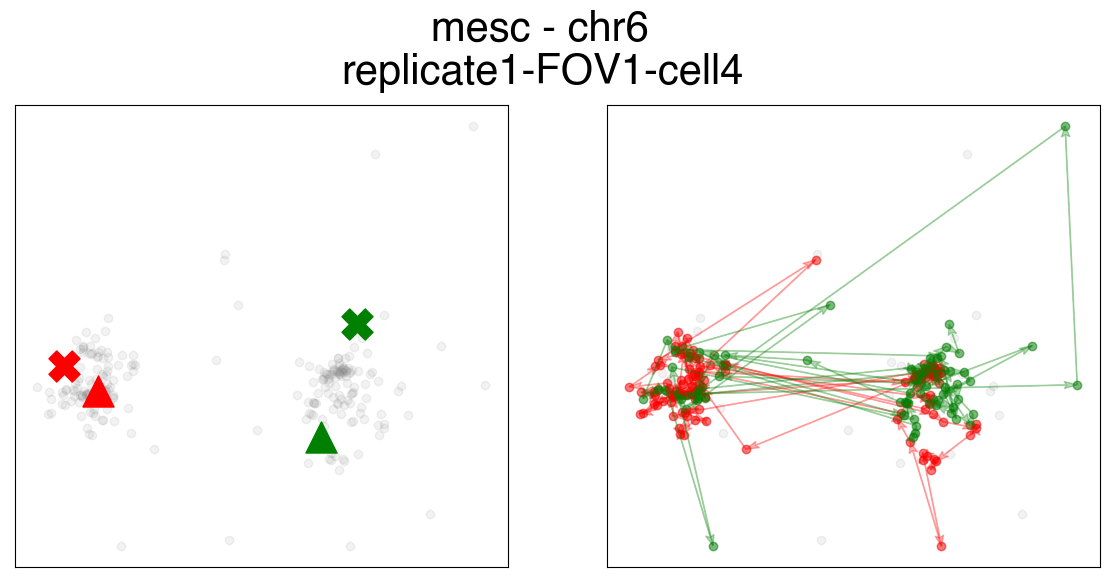

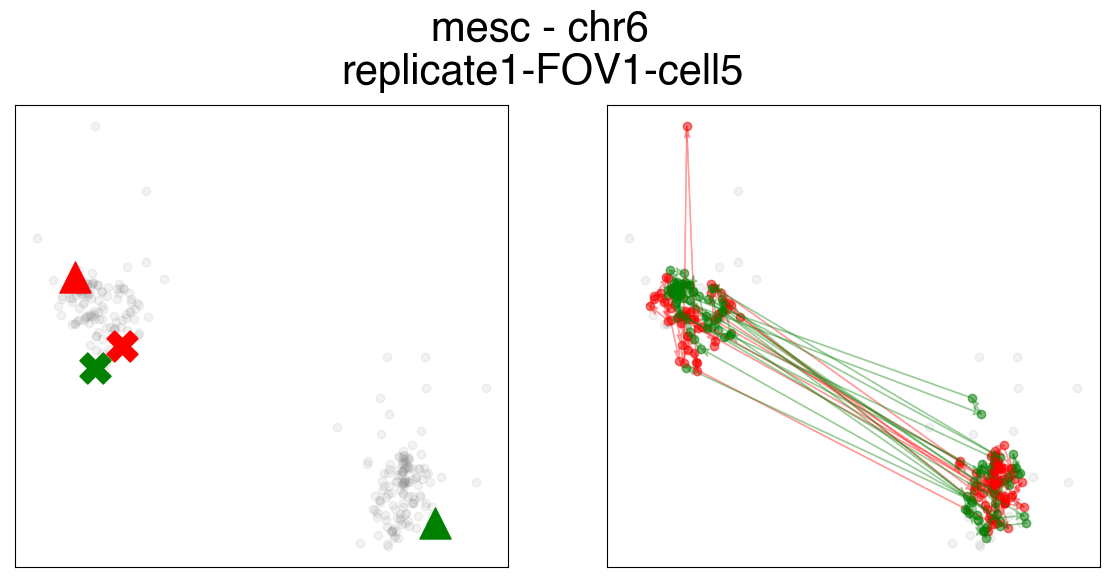

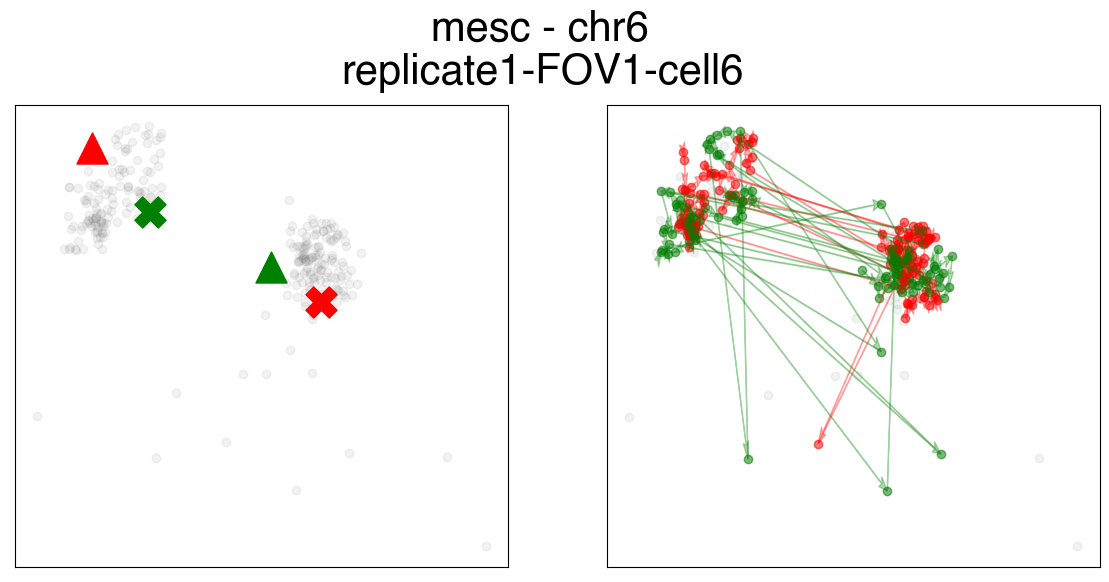

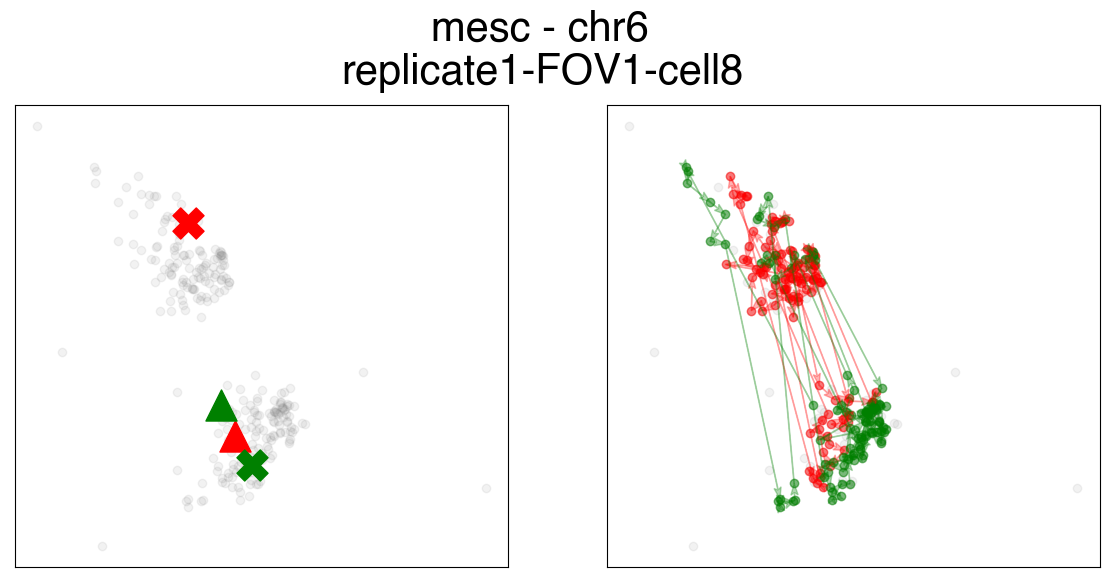

In [49]:
show_nucleus(res_all[0], background=True, title=None)
show_nucleus(res_all[1], background=True, title=None)
show_nucleus(res_all[2], background=True, title=None)
show_nucleus(res_all[3], background=True, title=None)

Since it is possible that entities thought to be different chromosome clusters may be selected, we separate chromosomes using the k-means method among the selected spots. 

In [50]:
res_all_allele = pd.DataFrame()

i = 0

for n_cell in range(len(res_all)):
    if len(res_all[n_cell]) > 1:
        for n_allele in range(len(res_all[n_cell])):
            a = res_all[n_cell][n_allele]
            a['Allele_ID'] = n_allele
            a['new_finalcellID'] = i
            i = i + 1
            res_all_allele = pd.concat([res_all_allele, a])
            #res_all_allele2.append([a])
    else :
        a = res_all[n_cell][0]
        a['Allele_ID'] = 0
        a['new_finalcellID'] = i
        i = i + 1
        #a = a.reset_index()                        
        res_all_allele = pd.concat([res_all_allele, a])
        #res_all_allele2.append([a])
        
res_all_allele['old_finalcellID'] = res_all_allele['finalcellID']
res_all_allele['finalcellID'] = res_all_allele['new_finalcellID']
res_all_allele

,replicate,FOV,cell,finalcellID,celltype,chr,hyb,geneID,x_hat,y_hat,z_hat,sig_x,sig_y,sig_z,Allele_ID,new_finalcellID,old_finalcellID
1,replicate1,1,4,0,mesc,chr6,0,Nanog_assoc#1,561.091077,207.518547,30.165820,1,1,1,0,0,0
2,replicate1,1,4,0,mesc,chr6,1,Non_Nanog_assoc#1,563.935066,210.304803,31.763496,1,1,1,0,0,0
5,replicate1,1,4,0,mesc,chr6,2,Nanog_assoc#2,561.893464,211.734352,33.976196,1,1,1,0,0,0
6,replicate1,1,4,0,mesc,chr6,3,Nanog_assoc#3,562.970370,215.593099,31.927050,1,1,1,0,0,0
7,replicate1,1,4,0,mesc,chr6,4,Foxp1,608.253058,202.147093,50.568457,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,replicate1,30,28,970,mesc,chr6,115,Ergic2,600.009301,545.064423,42.493858,1,1,1,0,970,672
151,replicate1,30,28,970,mesc,chr6,116,Rps4l,598.338215,544.600440,46.153844,1,1,1,0,970,672
152,replicate1,30,28,970,mesc,chr6,117,Caprin2,608.666086,547.494846,40.411927,1,1,1,0,970,672
154,replicate1,30,28,970,mesc,chr6,118,Nanog_assoc#20,609.622278,547.211054,40.800168,1,1,1,0,970,672


The following cell formats the data from res_all_allele, treating each allele as data for a single cell.

In [51]:
res_all_allele_2 = pd.DataFrame()
res_all_allele2 = []

for n_cell in list(set(res_all_allele['old_finalcellID'].values)):
    _df = res_all_allele.loc[res_all_allele["old_finalcellID"]==n_cell,].copy()
    if len(_df) > 100:
        # Convert from a Pandas DataFrame to a Numpy matrix (Array)
        cust_array = np.array([_df['x_hat'].tolist(),
                               _df['y_hat'].tolist(),
                               _df['z_hat'].tolist()
                               ], np.int32)

        # Transpose the matrix
        cust_array_t = cust_array.T

        # Perform cluster analysis (number of clusters = 2)
        cls = KMeans(n_clusters=2)
        pred = cls.fit_predict(cust_array_t)

        # Plot the centroids (centers of mass) of the clusters
        centers = cls.cluster_centers_

        _df = _df.reset_index()
        _df['Allele_ID'] = 0
        for i in range(len(_df)):
            b = np.array([_df['x_hat'][i],
                          _df['y_hat'][i],
                          _df['z_hat'][i]
                               ], np.int32)
            a = distance.euclidean(b, centers[0]) - distance.euclidean(b, centers[1])
            if a > 0:
                _df.loc[i,'Allele_ID'] = 1
    else :
        _df['Allele_ID'] = 0
    
    res_all_allele_2 = pd.concat([res_all_allele_2, _df])
    
    for i in range(2):
        res_all_allele2.append([_df.loc[_df['Allele_ID']==i,].copy()])

print("No of alleles = " + str(len(res_all_allele2)))

No of alleles = 1222


## Elimination of false positive data
Calculate the detection efficiency per target region and display the results. The median detection efficiency across all regions is indicated by a red line at half the median value.

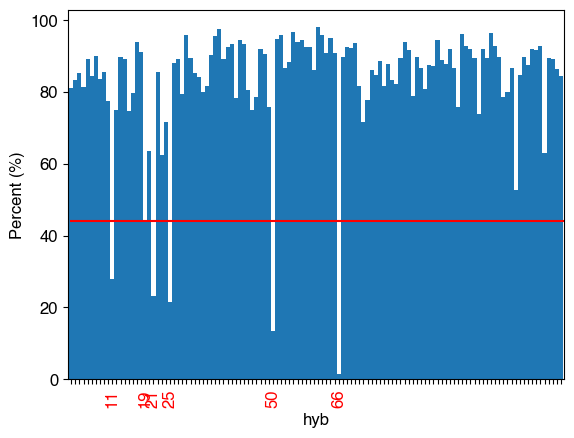

In [52]:
# Ignore specific runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice.")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in true_divide")

# Your plotting code here


# Set font size
plt.rcParams['font.size'] = 12

# Set font family
plt.rcParams['font.family'] = 'Helvetica'

df_res_concat_count = df_res_concat.loc[:,['hyb', 'geneID']].groupby('hyb').count()
# Calculate the number of unique values for 'new_finalcellID'
allele_unique = df_res_concat['new_finalcellID'].nunique()

# Divide df_res_concat_count by allele_unique and multiply by 100 to convert to percentage
df_res_concat_count = (df_res_concat_count / allele_unique) * 100

# Convert index back to column
df_res_concat_count.reset_index(inplace=True)

# Add 1 to the 'hyb' column
df_res_concat_count['hyb'] += 1

# Set 'hyb' back as index
df_res_concat_count.set_index('hyb', inplace=True)

threshold = int(df_res_concat_count.median().values[0])/2

# Identify hyb below threshold
below_threshold = df_res_concat_count[df_res_concat_count['geneID'] <= threshold].index

# Plot bar graph
ax = df_res_concat_count.plot(kind='bar', y='geneID', legend=False, width=1)

# Manipulate x-axis labels
for i, t in enumerate(ax.get_xticklabels()):
    if int(t.get_text()) in below_threshold:
        t.set_color('red')  # Set label to red
    else:
        t.set_visible(False)  # Make label invisible


plt.xlabel("hyb")
plt.ylabel("Percent (%)")
plt.plot([0, 120], [threshold, threshold], color="red")
plt.grid(False)

Calculate the distance from the median coordinates of bright spots within each chromosome and display their histogram.

Threshold : 34.956


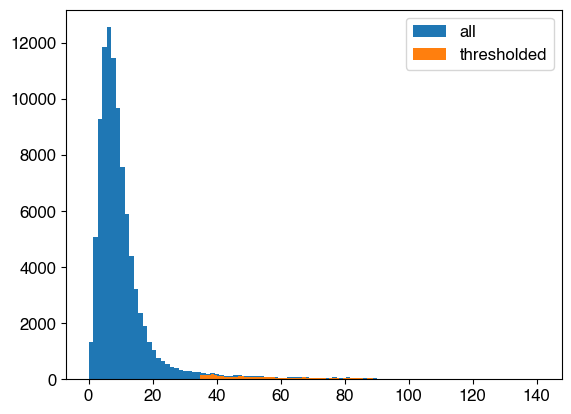

In [53]:
res_all_allele3 = []
for i in range(len(res_all_allele2)):
    _df = res_all_allele2[i][0].copy()
    _df['new_finalcellID'] = i
    _df['finalcellID'] = i
    _df = _df.reset_index()
    dist_1 = []
    
    for j in range(len(_df)):
        dist_1.append(distance.euclidean([_df['x_hat'].median(),
                                        _df['y_hat'].median(),
                                        _df['z_hat'].median()], 
                                       _df.loc[j,['x_hat','y_hat','z_hat']].values) )
        
    _df['dist_med'] = dist_1
    _df['allele_med_x'] = _df['x_hat'].median()
    _df['allele_med_y'] = _df['y_hat'].median()
    _df['allele_med_z'] = _df['z_hat'].median()
    
    
    res_all_allele3.append([_df])


a = pd.DataFrame()
for i in range(len(res_all_allele3)):
    a = pd.concat([a, res_all_allele3[i][0]])

_threshold = a['dist_med'].mean() + 2 * a['dist_med'].std()

formatted_output = f"Threshold : {round(_threshold, 3)}"
print(formatted_output)
_, _, _ = plt.hist(a['dist_med'], bins=100, label='all')
_, _, _ = plt.hist(a.loc[a['dist_med'] > _threshold, 'dist_med'], bins=100, label='thresholded')
plt.legend()
plt.show()


Exclude data where the distance from the median coordinates of spot locations within each chromosome exceeds the threshold of the average distance + 2× standard deviation (34.956).

In [54]:
_df = []
low_quality_hyb = below_threshold - 1
for i in range(len(res_all_allele3)):
    _df1 = res_all_allele3[i][0].copy()
    _df1 = _df1.loc[_df1['dist_med']<_threshold,:].copy()
    for b in low_quality_hyb:
        _df1 = _df1.loc[_df1['hyb'] != b, :].copy()
    _df.append([_df1])

res_all_red = _df

Exclude target regions with low spot detection efficiency (11, 19, 21, 25, 50, 66) from subsequent analyses. Also, exclude target regions (75, 85, 88) whose median distance matrix patterns significantly differed from Replicate 2 from further analysis. For details, please refer to Ohishi et al., bioRxiv, 2023.

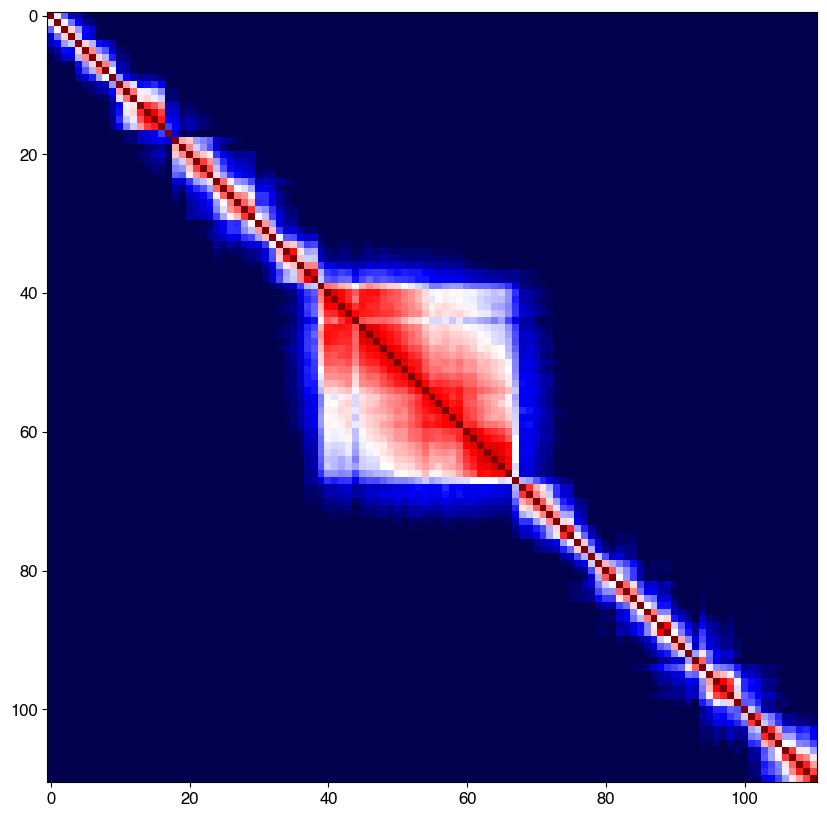

In [55]:
import pandas as pd
from scipy.stats import rankdata

# Initialize local variables
_df = pd.DataFrame()
low_quality_hyb = below_threshold - 1  # List of low-quality hybridizations
to_be_excuded = list(low_quality_hyb) + [74, 84, 87]  # List of hybs to be excluded. Excludes those with patterns clearly different from Replicate 2. For details, refer to Ohishi et al., bioRxiv, 2023.

# Select data that meets the conditions from res_all_allele3 and concatenate it into a DataFrame
for i in range(len(res_all_allele3)):
    _df1 = res_all_allele3[i][0].copy()
    _df1 = _df1.loc[_df1['dist_med'] < _threshold, :].copy()
    for b in to_be_excuded:
        _df1 = _df1.loc[_df1['hyb'] != b, :].copy()
    _df = pd.concat([_df, _df1])

# Update the 'hyb' values
_df['old_hyb'] = _df['hyb'].values.tolist()
b = _df['hyb'].unique().tolist()
b.sort()
c = rankdata(b).astype(int) - 1
for old, new in zip(b, c):
    _df.loc[_df['hyb'] == old, 'hyb'] = new

# Prepare the final data
res_all_red2 = []
for i in _df['finalcellID'].unique().tolist():
    _df1 = _df.loc[_df['finalcellID'] == i, :].copy()
    res_all_red2.append([_df1])

# Also, update gene_dist.
df_refgen2 = df_refgen.copy()

for i in to_be_excuded:
    df_refgen2 = df_refgen2[df_refgen2['hyb']!=i].copy()

for i in range(len(b)):
    df_refgen2.loc[df_refgen2['hyb']==b[i],'hyb'] = c[i]
df_refgen2['delta'] = df_refgen2['Start'] - df_refgen2['Start'].iloc[0]
    
# grab reference genome
gene_dist2 = df_refgen2[df_refgen2['Chrom'] == chosen_chrom]['delta']

# flatten
res_all_flat = [fiber for cell_res in res_all_red2 for fiber in cell_res]
med_dist_mat_all = plot.calc_med_dist_mat(res_all_flat, len(gene_dist2))

# plot
fig, axs = plt.subplots(figsize = (10, 10))
axs.imshow(med_dist_mat_all*100, cmap = 'seismic_r', vmax = 1000)

Display the distance matrix for each individual allele.

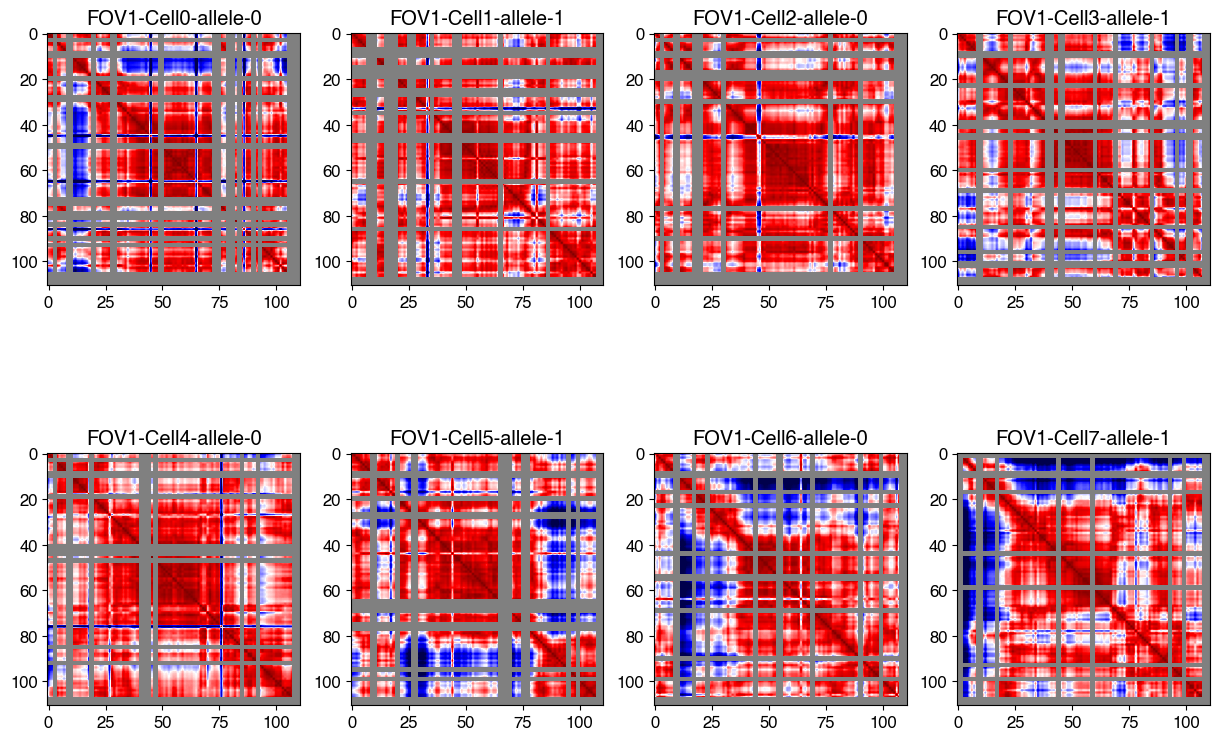

In [56]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Copy the colormap before modifying it
cmap = plt.get_cmap("seismic_r").copy()
cmap.set_bad("gray")

fig, axs = plt.subplots(2, 4, figsize=(15, 10))
# example_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8]

example_idxs = list(range(len(res_all_red2)))

for idx, ax in zip(example_idxs, axs.flatten()):
    
    # median distance matrix for single fiber
    mat = plot.calc_med_dist_mat([res_all_flat[idx]], len(gene_dist2))
    
    # grab metadata
    fov, cellid, allele = res_all_flat[idx].iloc[0]['FOV'], res_all_flat[idx].iloc[0]['finalcellID'], res_all_flat[idx].iloc[0]['Allele_ID']
    
    # show
    ax.imshow(mat*100, cmap=cmap, vmax=3000)
    # ax.set_title("{0}-FOV{1}-Cell{2} : {3}".format(rep, fov, cellid, chosen_chrom))
    ax.set_title("FOV{0}-Cell{1}-allele-{2}".format(fov, cellid, allele))


Save the data separated by allele as a CSV file.

In [57]:
all_chr_df = pd.DataFrame()

for i in range(len(res_all_red2)):
    a = res_all_red2[i]
    for j in range(len(a)):
        all_chr_df = pd.concat([all_chr_df, a[j]])
all_chr_df

os.makedirs(os.path.join(dir, "2_analyzed_data"), exist_ok=True)
all_chr_df.to_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_after_correction_rep1.csv"),
                        index = False)

## Removal of false positives in RNA-seqFISH
Here, we examine the relationship between RNA clusters detected by RNA-seqFISH and regions detected by DNA-seqFISH. If an RNA cluster detected by RNA-seqFISH is located near the coordinates of the corresponding gene determined by DNA-seqFISH, the cluster is considered to be a transcriptional spot (in a transcriptionally active state). The detection efficiency for gene regions by DNA-seqFISH is not 100%, and in some cases, DNA-seqFISH spots corresponding to the gene region may not be observed. Therefore, if the distance from the median coordinates of DNA-seqFISH spots on a specific chromosome exceeds the threshold used for DNA-seqFISH (34.956 px), it is considered that there was no transcription.

In [58]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy.spatial as ss
import shutil
import warnings
import zipfile

# Suppress specific warning
warnings.filterwarnings("ignore", message="loadtxt: Empty input file:")

# Obtain the path of the current directory.
current_directory = os.getcwd()
# Obtain the path two levels up from the current directory.
dir = os.path.dirname(current_directory)

# Name of the zip file to be moved.
zip_file = 'RNA_seqFISH_spot_detection.zip'

# The full path of the zip file.
full_zip_path = os.path.join(dir, "X1_accessory_data",zip_file)

# Check if the zip file exists
if os.path.exists(full_zip_path):
    # Unzip the zip file if it exists
    with zipfile.ZipFile(full_zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(dir, "X1_accessory_data"))
    
    # Delete the original zip file and any unnecessary files that appear as a result of unzipping
    os.remove(full_zip_path)



warnings.filterwarnings("ignore", message="loadtxt: Empty input file:")

DNA_seqFISH_coords = pd.read_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_after_correction_rep1.csv"))
DNA_seqFISH_coords = DNA_seqFISH_coords.drop(columns='level_0')
DNA_seqFISH_coords = DNA_seqFISH_coords.reset_index(drop=True).copy()
ref_data = pd.read_csv(os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv"))

RNA_target_list = ref_data.loc[(ref_data['exp_type']=='RNA_seqFISH') & (~ref_data['Locus_ID'].isna()),'target_ID'].tolist()
input_path = os.path.join(dir, "X1_accessory_data", "RNA_seqFISH_spot_detection")

DNA_seqFISH_coords['R_D_dist'] = float('nan')
DNA_seqFISH_coords['R_cluster_num'] = float('nan')

Transcription_state_summary = pd.DataFrame()

for RNA_id in RNA_target_list:
    print(RNA_id)
    Locus_id = ref_data.loc[ref_data['target_ID']==RNA_id,'Locus_ID'].tolist()
    geneID = ref_data.loc[(ref_data['exp_type']=='DNA_seqFISH') & (ref_data['Locus_ID']==Locus_id[0]),'geneID'].values[0]
    
    for Pos in range(1,31):        
        path = os.path.join(input_path, 'Pos'+str(Pos).zfill(2), '*'+RNA_id+'clusters.csv')
        l = glob.glob(path)
        
        cluster_data = np.loadtxt(l[0], delimiter=';')
        
        if len(cluster_data.shape)==1:
            if len(cluster_data)==5:
                if cluster_data[5]>0:
                    cluster_data = cluster_data[np.ravel(cluster_data[:,[5]])>0]

                    column_names = ["z", "y", "x", "R_cluster_num", "R_cluster_index", "cell"]
                    cluster_data_df = pd.DataFrame(cluster_data, columns=column_names)
                    cluster_data_df['FOV'] = Pos
                    cluster_data_df['FOV'] = Pos
                    cluster_data_df['RNA_id'] = RNA_id
                    cluster_data_df['Locus_id'] = Locus_id[0]
                    cluster_data_df['geneID'] = geneID[0]
                    cluster_data_df = cluster_data_df.reset_index(drop=True)

                    if (len(cluster_data)>0) & (sum((DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID))>0):
                        _df = DNA_seqFISH_coords.loc[(DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID),].copy()
            #             _df = _df.drop(columns='level_0')
                        _df = _df.reset_index(drop=False)
                        dna_coords = _df.loc[:,['allele_med_z','allele_med_y', 'allele_med_x']].values

                        # 最近傍の輝点を見つける。https://inarizuuuushi.hatenablog.com/entry/2019/02/21/100000
                        # kd tree の作成 (leafsizeは展開をしない節内点数上限)


                        if len(dna_coords.shape) == 1:
                            b = dna_coords[:,[0,1,2]].to_numpy() + 5000
                            cluster_data = np.vstack((dna_coords[:,[0,1,2]].to_numpy(), b))
                        tree = ss.KDTree(dna_coords[:,[0,1,2]])
            #             tree = ss.KDTree(cluster_data[:,[0,1,2]])

                        for j in range(len(cluster_data_df)):
                            d, i = tree.query(cluster_data[:,[0,1,2]][j])

                            cluster_data_df.loc[j,'R_D_dist'] = d
                            cluster_data_df.loc[j,'Allele_ID'] = _df.loc[i,['Allele_ID']].values
                            cluster_data_df.loc[j,'finalcellID'] = _df.loc[i,['finalcellID']].values

                        Transcription_state_summary = pd.concat([Transcription_state_summary,cluster_data_df])
        
        else:
            if any(cluster_data[:,[5]])>0:
                cluster_data = cluster_data[np.ravel(cluster_data[:,[5]])>0]

                column_names = ["z", "y", "x", "R_cluster_num", "R_cluster_index", "cell"]
                cluster_data_df = pd.DataFrame(cluster_data, columns=column_names)
                cluster_data_df['FOV'] = Pos
                cluster_data_df['FOV'] = Pos
                cluster_data_df['RNA_id'] = RNA_id
                cluster_data_df['Locus_id'] = Locus_id[0]
                cluster_data_df['geneID'] = geneID
                cluster_data_df = cluster_data_df.reset_index(drop=True)

                if (len(cluster_data)>0) & (sum((DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID))>0):
                    _df = DNA_seqFISH_coords.loc[(DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID),].copy()
        #             _df = _df.drop(columns='level_0')
                    _df = _df.reset_index(drop=False)
                    dna_coords = _df.loc[:,['allele_med_z','allele_med_y', 'allele_med_x']].values

                    # 最近傍の輝点を見つける。https://inarizuuuushi.hatenablog.com/entry/2019/02/21/100000
                    # kd tree の作成 (leafsizeは展開をしない節内点数上限)


                    if len(dna_coords.shape) == 1:
                        b = dna_coords[:,[0,1,2]].to_numpy() + 5000
                        cluster_data = np.vstack((dna_coords[:,[0,1,2]].to_numpy(), b))
                    tree = ss.KDTree(dna_coords[:,[0,1,2]])
        #             tree = ss.KDTree(cluster_data[:,[0,1,2]])

                    for j in range(len(cluster_data_df)):
                        d, i = tree.query(cluster_data[:,[0,1,2]][j])

                        cluster_data_df.loc[j,'R_D_dist'] = d
                        cluster_data_df.loc[j,'Allele_ID'] = _df.loc[i,['Allele_ID']].values[0]
                        cluster_data_df.loc[j,'finalcellID'] = _df.loc[i,['finalcellID']].values[0]

                    Transcription_state_summary = pd.concat([Transcription_state_summary,cluster_data_df])
                    

print("Threshold : 34.956")
print("Number of ON locus : ", sum(Transcription_state_summary['R_D_dist']<34.956))
new_dataset = Transcription_state_summary[Transcription_state_summary['R_D_dist'] < 34.956]

new_dataset.to_csv(os.path.join(dir, "2_analyzed_data", "Transcription_state_data_rep1.csv"), index=False)

new_dataset